## BÀI THỰC HÀNH BIẾN HÌNH XỬ LÝ ẢNH
### NGUYỄN THANH TRÚC - 20110342
### VGG11 - part 3



## Data Preprocessing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [5]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

In [6]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [42]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [43]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [44]:
OUTPUT_DIM = 10

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [45]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained=True)

print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:10<00:00, 51.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [46]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [47]:
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [48]:
pretrained_model.classifier[-1] = final_fc

In [49]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


In [50]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [51]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 128,812,810 trainable parameters


In [52]:
for parameter in model.features.parameters():
    parameter.requires_grad = False
for parameter in model.classifier[:-1].parameters():
    parameter.requires_grad = False

### Data Processing


In [53]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [54]:
import os
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Đường dẫn đến tệp zip
zip_path = '/content/drive/MyDrive/Colab Notebooks/cats_and_dogs_filtered.zip'
extracted_path = '/content/drive/MyDrive/Colab Notebooks/cats_and_dogs_filtered'

# Giải nén tệp zip
if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks')

# Biến đổi ảnh ở tập train và tập test
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Tải toàn bộ dữ liệu
full_data = datasets.ImageFolder(os.path.join(extracted_path, 'train'), transform=train_transforms)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size
train_data, test_data = random_split(full_data, [train_size, test_size])

# Biến đổi ảnh ở tập test
test_data.dataset.transform = test_transforms

ROOT = '.data'

In [55]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [56]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [57]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 1440
Number of validation examples: 160
Number of testing examples: 400


In [58]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

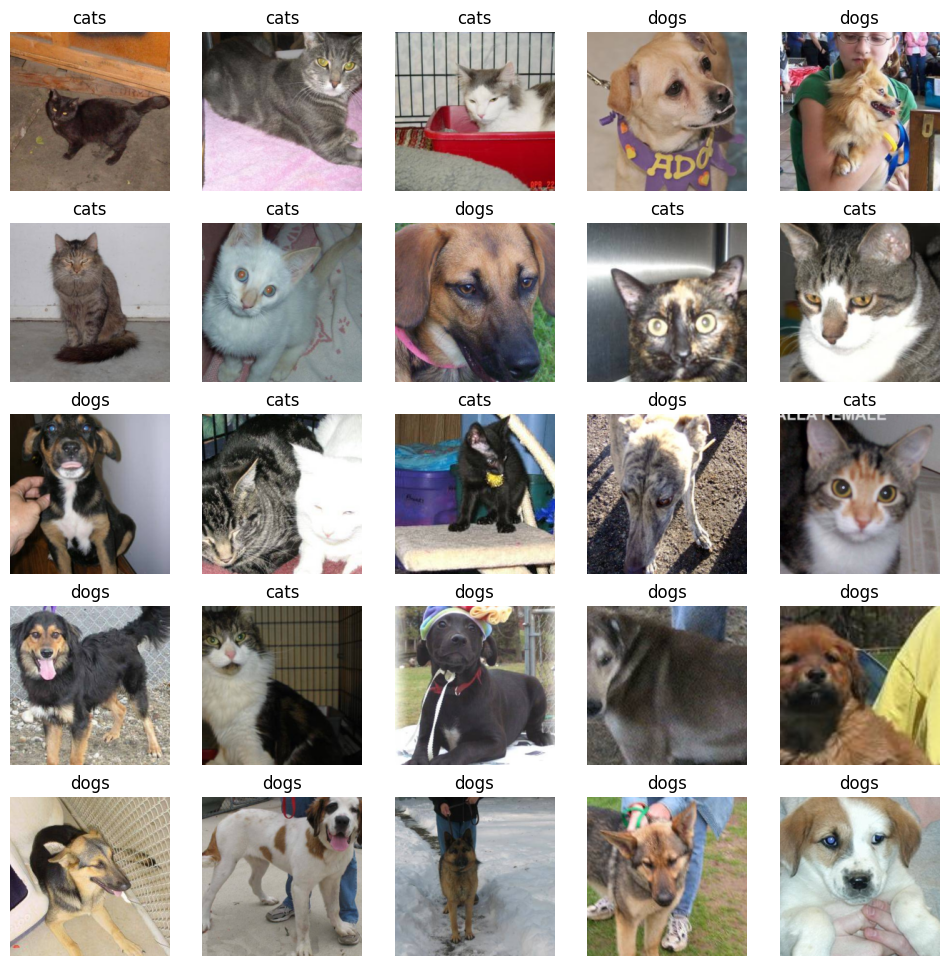

In [59]:

classes = full_data.classes

N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])



def plot_images(images, labels, classes):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = axes[i // 5, i % 5]
        ax.imshow(img.permute(1, 2, 0))  # Chuyển vị để đưa kênh màu lên cuối
        ax.set_title(classes[label])
        ax.axis('off')
    plt.show()

# Gọi hàm plot_images
plot_images(images, labels, classes)

In [60]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Training the Model

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [62]:
FOUND_LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

In [63]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [64]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [65]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [66]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [67]:
EPOCHS = 2

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 1.381 | Train Acc: 51.89%
	 Val. Loss: 0.569 |  Val. Acc: 88.75%


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 0.394 | Train Acc: 91.59%
	 Val. Loss: 0.282 |  Val. Acc: 95.63%


In [68]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 0.326 | Test Acc: 92.66%


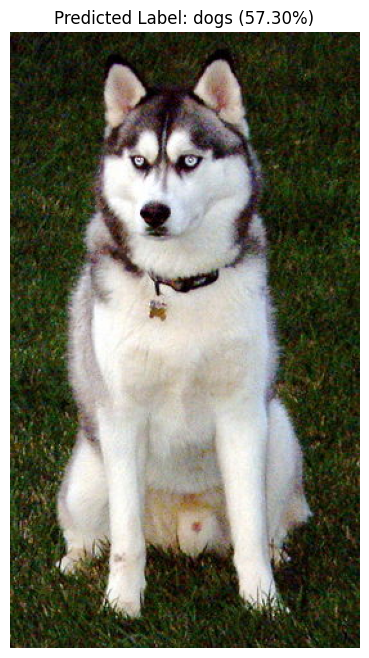

In [70]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# hàm để dự đoán nhãn của ảnh 
def predict(model, image_path, device, classes):
    # Chuyển đổi ảnh 
    transform = transforms.Compose([
        transforms.Resize(pretrained_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
    ])

    # Mở ảnh và áp dụng chuyển đổi
    original_image = Image.open(image_path).convert('RGB')
    image = transform(original_image).unsqueeze(0).to(device)

    # Đánh giá mô hình
    model.eval()

    with torch.no_grad():
        y_pred, _ = model(image)
        pred_prob = torch.softmax(y_pred, dim=1)
        pred_label = pred_prob.argmax(dim=1, keepdim=True).item()

    # Lấy nhãn thực và xác suất dự đoán
    pred_label_name = classes[pred_label]
    pred_label_prob = pred_prob[0, pred_label].item() * 100

    return original_image, pred_label_name, pred_label_prob


# Đường dẫn tới ảnh cần dự đoán
image_path = '/content/drive/MyDrive/Colab Notebooks/fn.jpg'

# Dự đoán nhãn cho ảnh
original_image, pred_label, pred_prob = predict(model, image_path, device, classes)

# Hiển thị ảnh gốc cùng với nhãn dự đoán và xác suất
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title(f'Predicted Label: {pred_label} ({pred_prob:.2f}%)')
plt.axis('off')
plt.show()
